<a href="https://colab.research.google.com/github/eshal26/PCA-CNN/blob/main/inception_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
#importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
import shutil
import sklearn
from sklearn.model_selection import train_test_split

In [19]:
train_dir = 'train_dataset'
val_dir = 'validation_dataset'
test_dir = 'test_dataset'

# Define transformations for training, validation, and testing data
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.8245, 0.8547, 0.9387], std = [0.1323, 0.1431, 0.0530])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.8245, 0.8547, 0.9387], std = [0.1323, 0.1431, 0.0530])
])

# Create datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [20]:
import torch
import torch.nn as nn
from sklearn.decomposition import PCA
import numpy as np

class SimpleInceptionBlock(nn.Module):
    def __init__(self, in_channels):
        super(SimpleInceptionBlock, self).__init__()

        # 3x3 convolution branch with ReLU activation
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # 3x3 max pooling followed by 1x1 convolution branch with ReLU activation
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, 16, kernel_size=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        branch3x3_out = self.branch3x3(x)
        branch_pool_out = self.branch_pool(x)
        outputs = [branch3x3_out, branch_pool_out]
        return torch.cat(outputs, 1)  # Concatenate along channel dimension

class SimpleInceptionModelWithPCA(nn.Module):
    def __init__(self, pca_components=90, pca=None):
        super(SimpleInceptionModelWithPCA, self).__init__()

        # Initial convolutional layer with increased stride for feature size reduction
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # Stride set to 2
            nn.ReLU(inplace=True)
        )

        # Inception block
        self.inception = SimpleInceptionBlock(16)

        # Add aggressive pooling after inception block
        self.pool = nn.AdaptiveAvgPool2d((4, 4))  # Reduce output spatial size to 4x4

        # Dropout layers
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)

        # PCA Parameters
        self.pca = pca  # Accept PCA instance externally or set to None
        self.pca_components = pca_components

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self.pca_components, 64)
        self.fc2 = nn.Linear(64, 2)  # Output layer for binary classification

    def _get_flatten_size(self):
        # Dynamically compute the flatten size by passing a dummy tensor
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 224, 224)
            x = self.conv1(dummy_input)
            x = self.inception(x)
            x = self.pool(x)
            x = self.flatten(x)
        return x.shape[1]

    def extract_features(self, x):
        """Extract features before passing them to fully connected layers."""
        x = self.conv1(x)
        x = self.inception(x)
        x = self.pool(x)
        x = self.flatten(x)
        return x

    def forward(self, x):
        x = self.extract_features(x)
        device = x.device

        # Apply PCA if it is fitted
        if self.pca is not None:
            x_cpu = x.detach().cpu().numpy()  # Convert tensor to NumPy array
            x_pca = self.pca.transform(x_cpu)  # Apply PCA transformation
            x = torch.from_numpy(x_pca).to(device, dtype=torch.float32)  # Back to PyTorch tensor
        else:
            raise RuntimeError("PCA must be fitted before the forward pass")

        x = self.dropout1(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)  # Apply ReLU activation after the first fully connected layer
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

    def fit_pca(self, dataloader, num_components=90):
        """
        Fit PCA on the extracted features of the model.
        """
        self.eval()  # Ensure model is in eval mode
        features = []

        with torch.no_grad():
            for inputs, _ in dataloader:
                inputs = inputs.to(next(self.parameters()).device)
                x = self.extract_features(inputs)
                features.append(x.cpu().numpy())

        features = np.vstack(features)  # Combine all features
        pca = PCA(n_components=num_components)
        pca.fit(features)
        self.pca = pca  # Assign the fitted PCA to the model



model = SimpleInceptionModelWithPCA(pca_components=90)



In [21]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.to(device)

    # Step 1: Fit PCA on training data
    model.fit_pca(train_loader, num_components=model.pca_components)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 30)

        # Training Phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track statistics
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

        train_loss = running_loss / total_samples
        train_acc = running_corrects.double() / total_samples

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_samples = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Track statistics
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
                val_samples += inputs.size(0)

        val_loss = val_loss / val_samples
        val_acc = val_corrects.double() / val_samples

        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    return model



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 30
learning_rate = 0.001


# Criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device=device)


Epoch 1/30
------------------------------
Train Loss: 0.5986 Acc: 0.6909
Val Loss: 0.4439 Acc: 0.8462
Epoch 2/30
------------------------------
Train Loss: 0.3789 Acc: 0.8445
Val Loss: 0.3282 Acc: 0.8462
Epoch 3/30
------------------------------
Train Loss: 0.3421 Acc: 0.8556
Val Loss: 0.2934 Acc: 0.8769
Epoch 4/30
------------------------------
Train Loss: 0.3185 Acc: 0.8675
Val Loss: 0.2684 Acc: 0.8923
Epoch 5/30
------------------------------
Train Loss: 0.2987 Acc: 0.8756
Val Loss: 0.2484 Acc: 0.8923
Epoch 6/30
------------------------------
Train Loss: 0.2880 Acc: 0.8894
Val Loss: 0.2278 Acc: 0.9015
Epoch 7/30
------------------------------
Train Loss: 0.2681 Acc: 0.8936
Val Loss: 0.2062 Acc: 0.9169
Epoch 8/30
------------------------------
Train Loss: 0.2665 Acc: 0.8921
Val Loss: 0.1948 Acc: 0.9477
Epoch 9/30
------------------------------
Train Loss: 0.2479 Acc: 0.9048
Val Loss: 0.1771 Acc: 0.9600
Epoch 10/30
------------------------------
Train Loss: 0.2434 Acc: 0.9082
Val Loss

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, test_loader, criterion, device):
    """
    Evaluate the model on the test dataset.

    Parameters:
        model (torch.nn.Module): Trained model to evaluate.
        test_loader (DataLoader): DataLoader for the test dataset.
        criterion (loss function): Loss function used during training.
        device (torch.device): Device to perform computation on (CPU or GPU).

    Returns:
        dict: A dictionary containing test loss, accuracy, and optionally other metrics.
    """
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    correct_preds = 0
    total_samples = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():  # No need to compute gradients
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Accumulate loss
            test_loss += loss.item() * inputs.size(0)

            # Get predictions
            _, preds = torch.max(outputs, 1)

            # Accumulate correct predictions
            correct_preds += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

            # Collect predictions and labels for detailed metrics
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Compute average loss and accuracy
    avg_loss = test_loss / total_samples
    accuracy = correct_preds.double() / total_samples

    # Compute detailed metrics
    class_report = classification_report(all_labels, all_preds, output_dict=True)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Print metrics
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))
    print("\nConfusion Matrix:")
    print(conf_matrix)

    return {
        "loss": avg_loss,
        "accuracy": accuracy.item(),
        "classification_report": class_report,
        "confusion_matrix": conf_matrix,
    }

# Example Usage:
# Assuming `test_loader` is a DataLoader for your test dataset
test_results = evaluate_model(trained_model, test_loader, criterion, device)


Test Loss: 0.1107
Test Accuracy: 0.9694

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.84      0.90        51
           1       0.97      0.99      0.98       276

    accuracy                           0.97       327
   macro avg       0.96      0.92      0.94       327
weighted avg       0.97      0.97      0.97       327


Confusion Matrix:
[[ 43   8]
 [  2 274]]


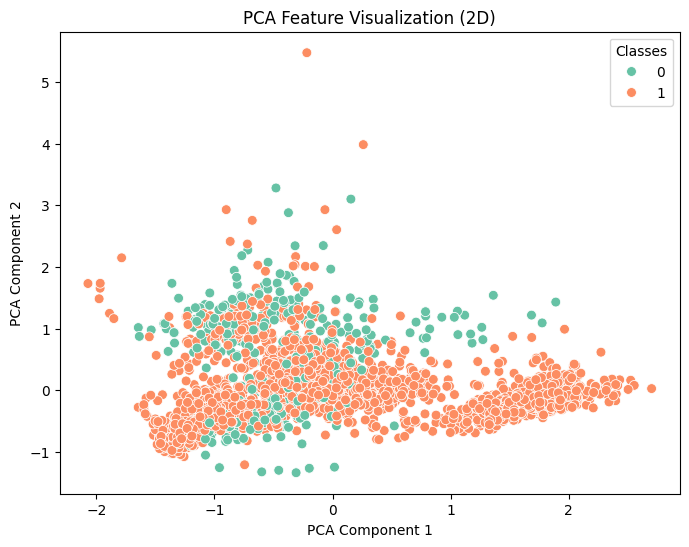

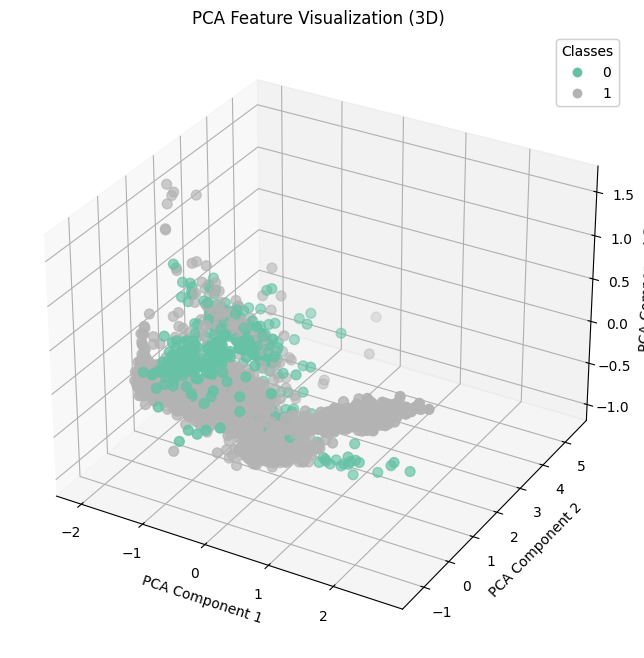

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

def plot_pca_features(model, dataloader, num_components=2):
    """
    Extract features using the model, transform them with PCA, and plot in 2D/3D.
    """
    model.eval()
    features = []
    labels = []

    # Extract features and labels
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(next(model.parameters()).device)
            x = model.extract_features(inputs)
            features.append(x.cpu().numpy())
            labels.append(targets.cpu().numpy())

    # Combine all features and labels
    features = np.vstack(features)
    labels = np.concatenate(labels)

    # Apply PCA for visualization
    pca = PCA(n_components=num_components)
    transformed_features = pca.fit_transform(features)

    # 2D Plot
    if num_components == 2:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            x=transformed_features[:, 0],
            y=transformed_features[:, 1],
            hue=labels,
            palette="Set2",
            s=50,
        )
        plt.title("PCA Feature Visualization (2D)")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.legend(title="Classes")
        plt.show()

    # 3D Plot
    elif num_components == 3:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection="3d")
        scatter = ax.scatter(
            transformed_features[:, 0],
            transformed_features[:, 1],
            transformed_features[:, 2],
            c=labels,
            cmap="Set2",
            s=50,
        )
        ax.set_title("PCA Feature Visualization (3D)")
        ax.set_xlabel("PCA Component 1")
        ax.set_ylabel("PCA Component 2")
        ax.set_zlabel("PCA Component 3")
        legend = ax.legend(*scatter.legend_elements(), title="Classes")
        ax.add_artist(legend)
        plt.show()
    else:
        raise ValueError("num_components must be 2 or 3 for visualization.")

# Assuming `model` is trained, and `train_loader` or `test_loader` is available
plot_pca_features(model, train_loader, num_components=2)  # 2D plot
plot_pca_features(model, train_loader, num_components=3)  # 3D plot


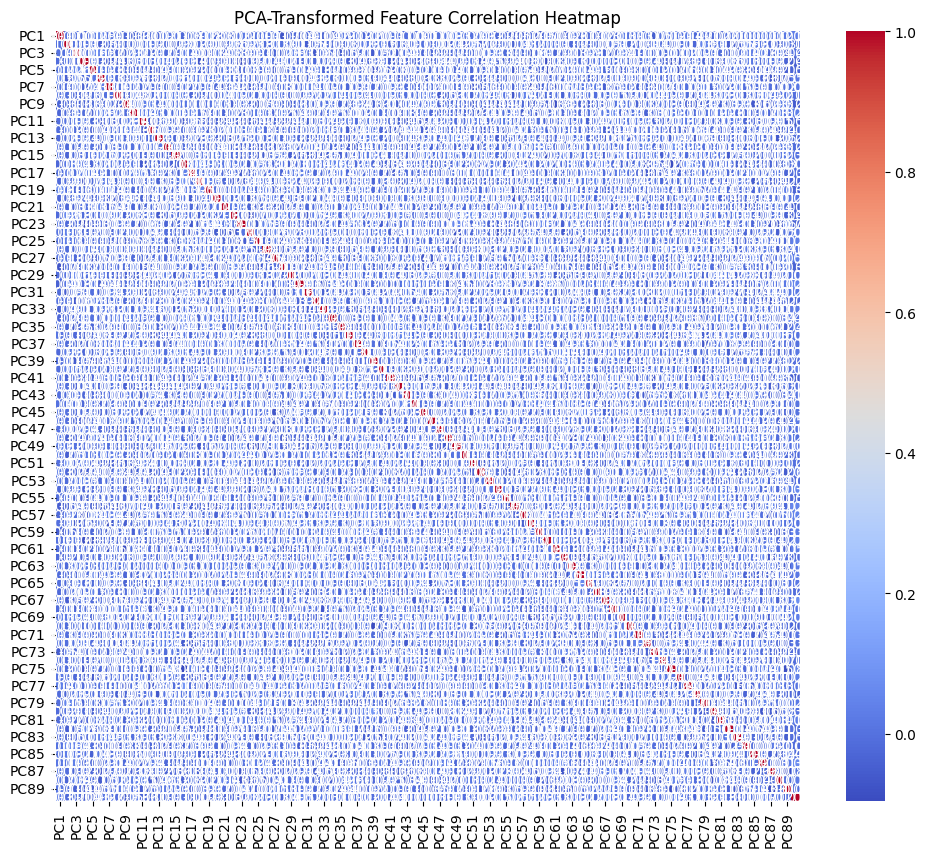

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure the model is in evaluation mode
model.eval()

# Step 1: Extract PCA-Transformed Features from Model
pca_features = []

with torch.no_grad():
    for inputs, _ in train_loader:  # Assuming `train_loader` is defined
        inputs = inputs.to(next(model.parameters()).device)

        # Extract raw features
        raw_features = model.extract_features(inputs)

        # Apply PCA transformation
        transformed_features = model.pca.transform(raw_features.cpu().numpy())
        pca_features.append(transformed_features)

# Combine all features into a single array
pca_features = np.vstack(pca_features)

# Step 2: Create a DataFrame
pca_features_df = pd.DataFrame(pca_features, columns=[f"PC{i+1}" for i in range(pca_features.shape[1])])

# Step 3: Compute Correlation Matrix
correlation_matrix = pca_features_df.corr()

# Step 4: Plot Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f", cbar=True)
plt.title("PCA-Transformed Feature Correlation Heatmap")
plt.show()
